In [1]:
import torch 
import torchvision.utils as vutils 
from model import Discriminator, Encoder, Generator
from dataloader import get_cifar_10

device = torch.device("cpu")
dataloader = get_cifar_10(batch_size=128)
latent_dim=256

gen = Generator(latent_dim)
dis = Discriminator(latent_dim, wasserstein=False)
enc = Encoder(latent_dim)


Files already downloaded and verified


In [2]:
gen_model_path = "./models/generator_600.pth"
enc_model_path = "./models/encoder_600.pth"
dis_model_path = "./models/discriminator_600.pth"

gen.load_state_dict(torch.load(gen_model_path))
enc.load_state_dict(torch.load(enc_model_path))
dis.load_state_dict(torch.load(dis_model_path))
gen.to(device)
enc.to(device)
dis.to(device)
gen.eval()
dis.eval()
enc.eval()

Encoder(
  (encStack): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1, inplace=True)
    (3): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.1, inplace=True)
    (6): Conv2d(64, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.1, inplace=True)
    (9): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), bias=False)
    (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.1, inplace=True)
    (12): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (13): BatchNorm2d(512, eps=1e

In [3]:
test_loader = dataloader

In [4]:
z_real = []
for idx,  (x, _) in enumerate(test_loader):
    # Defining labels 
    y_true = torch.ones(x.size(0), 1).to(device)
    y_fake = torch.zeros(x.size(0),1).to(device)

    # Noise for improving training 
    noise1 = torch.Tensor(x.size()).normal_(0, 0.001).to(device)
    noise2 = torch.Tensor(x.size()).normal_(0, 0.001).to(device)
                

    # Generator 
    z_fake =torch.randn((x.size(0),latent_dim, 1, 1)).to(device)#, requires_grad=False)
    x_fake = gen(z_fake)

    # Encoder
    x_true = x.float().to(device)
    z_true = enc(x_true)
    # out_true = dis(x_true + noise1, z_true)#.view(self.batch_sie, self.latent_dim, 1, 1))
    # out_fake = dis(x_fake + noise2, z_fake)

    z_real.append(z_true)

    if idx % 50 == 0:
        status = f"Iter:{idx} / {len(test_loader)}"
        print(status)
        vutils.save_image(torch.cat([x_true.data[:16], x_fake.data[:16]]), f'./reconstruction/comparison/{idx}.png')




Iter:0 / 391
Iter:50 / 391
Iter:100 / 391
Iter:150 / 391
Iter:200 / 391
Iter:250 / 391
Iter:300 / 391
Iter:350 / 391


In [5]:
z = torch.stack([item for item in z_real[:-1]])

In [6]:
z.size()

torch.Size([390, 128, 256, 1, 1])

In [7]:
Z = z.view(z.size()[0] * z.size()[1], z.size()[2] )

In [8]:
Z.size()

torch.Size([49920, 256])

In [9]:
# samples from q(z|x)
latent = Z.detach().numpy()

In [10]:
latent.shape

(49920, 256)

In [11]:
from sklearn.manifold import TSNE
import numpy as np
latent_embeded = TSNE(n_components=2, init="random").fit_transform( np.asarray(latent, dtype='float32'))

In [13]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=15)
kmeans.fit(latent_embeded)
y_kmeans = kmeans.predict(latent_embeded)

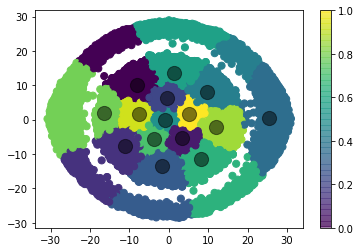

In [19]:
import matplotlib.pyplot as plt 
from pylab import *
cmap = cm.get_cmap('PiYG', 10) 

plt.scatter(latent_embeded[:, 0], latent_embeded[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5, cmap=cmap);

plt.colorbar()